In [1]:
# from google.colab import drive
# import sys
# drive.mount('/content/drive',force_remount=True)
# sys.path.insert(0,'/content/drive/MyDrive/EPF notebooks/deep_learning_project')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

from package import batch_gd, report,train_dataset, test_dataset, \
    transforms, train_loader, test_loader

# **Transfer learning**
### **Comparing our CNN with a pretrained EfficientNet**
In this notebook we'll compare our previous model with a pretrained EfficientNet. 

Indeed, after analyzing the performances of several pretrained models on the ImageNet dataset, I decided that the EfficientNet was a good compromise between a relatively low amount of parameters and high performances.

To implement transfer learning in PyTorch, I used the following tutorial :

Reference: https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/

In [3]:
def build_model(pretrained=True, fine_tune=True, num_classes=43):
  """
  pretrained: boolean value indicating whether we want to load the ImageNet weights or not
  fine_tune: boolean value. When it is True, all the intermediate layers will also be trained
  """
  if pretrained:
      print('Loading pre-trained weights')
      model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
  else:
      print('Not loading pre-trained weights')
      model = models.efficientnet_v2_s()
  if fine_tune:
      print('Fine-tuning all layers')
      for params in model.parameters():
          params.requires_grad = True
  elif not fine_tune:
      print('Freezing hidden layers')
      for params in model.parameters():
          params.requires_grad = False
  # Change the final classification head
  model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
  return model

In [4]:
model = build_model(pretrained=True, fine_tune=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Loading pre-trained weights
Fine-tuning all layers


In [5]:
#model # uncomment to see the full architecture

We are only interested in the last layer (the classifier). Indeed we'll replace it with a new layer to act as a new classifier. Here 1280 input features will be needed.

```Python 
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

In [6]:
train_losses, test_losses = batch_gd(model=model,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    train_loader=train_loader,
                                    test_loader=test_loader,
                                    early_stopping=False,
                                    early_stopper=None,
                                    epochs=10)

  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1 / 10: Train Loss : 0.2671, Test Loss : 0.1774, duration: 0:02:19.921678


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2 / 10: Train Loss : 0.0268, Test Loss : 0.0782, duration: 0:02:17.908765


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3 / 10: Train Loss : 0.0332, Test Loss : 0.0831, duration: 0:02:17.081046


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4 / 10: Train Loss : 0.0124, Test Loss : 0.0992, duration: 0:02:17.813418


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5 / 10: Train Loss : 0.0098, Test Loss : 0.0688, duration: 0:02:16.994909


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6 / 10: Train Loss : 0.0151, Test Loss : 0.0717, duration: 0:02:17.617870


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7 / 10: Train Loss : 0.0101, Test Loss : 0.1588, duration: 0:02:16.890911


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 8 / 10: Train Loss : 0.0066, Test Loss : 0.0759, duration: 0:02:17.490635


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 9 / 10: Train Loss : 0.0228, Test Loss : 0.1082, duration: 0:02:16.989368


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch 10 / 10: Train Loss : 0.0277, Test Loss : 0.0480, duration: 0:02:17.789185


In [7]:
WEIGHTS_PATH = '/content/drive/MyDrive/EPF notebooks/deep_learning_project/efficient_net_full_training'
torch.save(model.state_dict(), WEIGHTS_PATH)

In [8]:
model.load_state_dict(torch.load(WEIGHTS_PATH))
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
# reduce the batch size and empty the cach to avoid memory issues
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)
torch.cuda.empty_cache()

  0%|          | 0/198 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        60
         1.0       1.00      1.00      1.00       720
         2.0       0.99      0.99      0.99       750
         3.0       0.99      1.00      0.99       450
         4.0       1.00      0.99      1.00       660
         5.0       0.94      0.99      0.96       630
         6.0       1.00      0.91      0.95       150
         7.0       0.99      1.00      1.00       450
         8.0       1.00      0.94      0.97       450
         9.0       1.00      1.00      1.00       480
        10.0       1.00      1.00      1.00       660
        11.0       0.99      1.00      0.99       420
        12.0       1.00      0.97      0.98       690
        13.0       0.98      1.00      0.99       720
        14.0       1.00      1.00      1.00       270
        15.0       0.99      1.00      0.99       210
        16.0       1.00      1.00      1.00       150
        17.0       1.00    

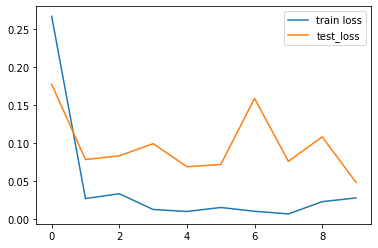

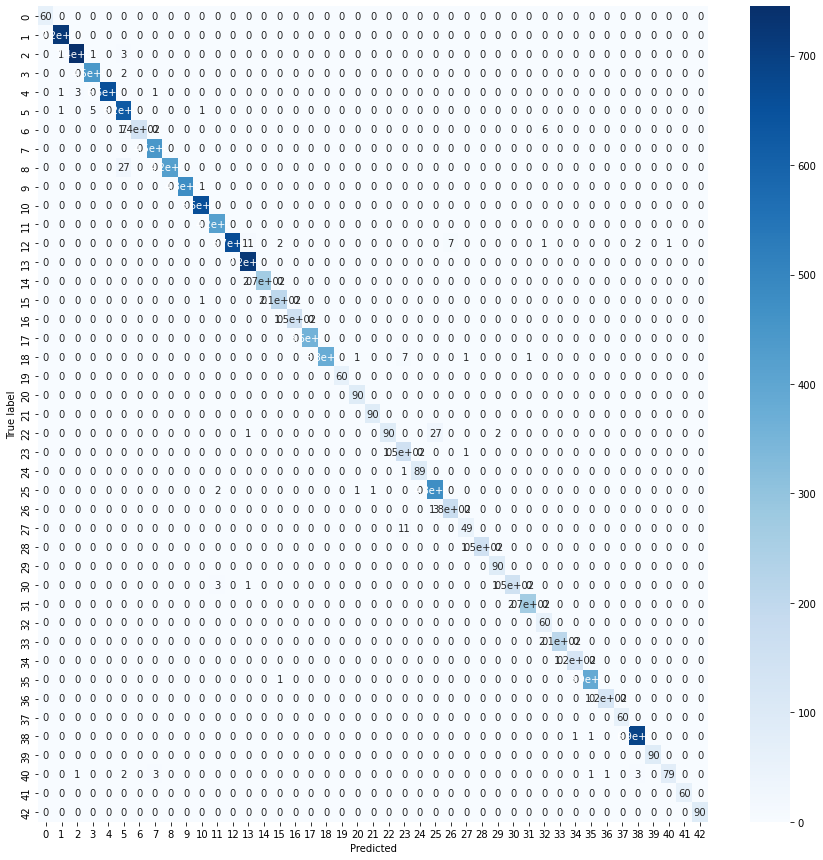

In [11]:
X_test, p_test, y_test = report(model,test_loader, train_losses, test_losses)